In [ ]:
!mkdir -p ./kaggle
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 65% 39.0M/60.3M [00:00<00:00, 204MB/s]
100% 60.3M/60.3M [00:00<00:00, 216MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/drive/MyDrive/emo_detection

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65242339.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65267116.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65426218.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65430136.jpg  
  inflating: /content/driv

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from keras.utils import plot_model


## Setting up Directory to save model

In [9]:
os.makedirs('test_dir', exist_ok = True)

In [10]:
#define project name
project_name = 'FER_2013_Emotion_Detection'

#list of models

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir ='/content/drive/MyDrive/emo_detection'

#create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

#create a subdirectory for each model
for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os,os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at" {project_dir}')

Project directory structure created at" /content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection


## Data Cleaning

In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/drive/MyDrive/emo_detection/train'

#walk though all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files:
    #construct the path to the current file
    file_path = os.path.join(root, file)

    try:
      file_type = imghdr.what(file_path)
      #if the file extension is not in the allowed list, remove it
      if file_type not in image_exts:
        print(f'Image not in exist list {file_path}')
        os.remove(file_path)

      else:
        #Proceed to process the image if needed
        img = cv2.imread(file_path)

    except Exception as e:
      #print out the issue and the path of the problematic file
      print(f'Issue with file {file_path}. Error: {e}')
      #Optionally, remove files that cause exceptions
      os.remove(file_path)


##Data Analysis

In [11]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
  count ={}
  for item in os.listdir(directory):
    #Construct the full path to the item
    item_path = os.path.join(directory, item)

    #check if item is a directory
    if os.path.isdir(item_path):
      count[item]= len(os.listdir(item_path))

  #convert the counts directory to a dataframe for easy viewing and analysis
  #the index of the datafreame is set to the provided set name
  df = pd.DataFrame(count, index = [set_name])
  return df

#Paths to the training and testing directories
train_dir = '/content/drive/MyDrive/emo_detection/train'
test_dir = '/content/drive/MyDrive/emo_detection/test'

#count the files in the subdirectories of the training directory and print the result
train_count  = count_files_in_subdirs(train_dir, 'train')
print(train_count)

#count the files in the subdirectory of the testing directory and print the result
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

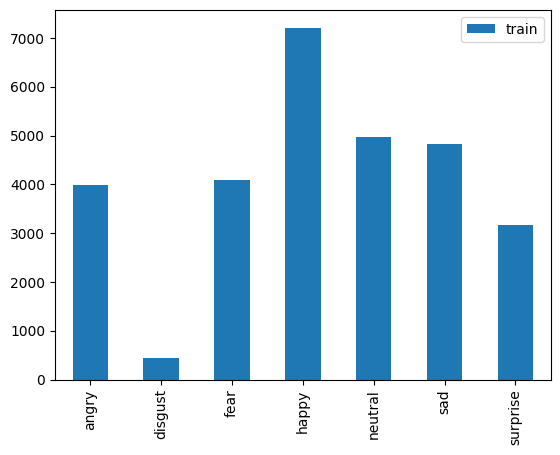

In [12]:
train_count.transpose().plot(kind = 'bar')

<Axes: >

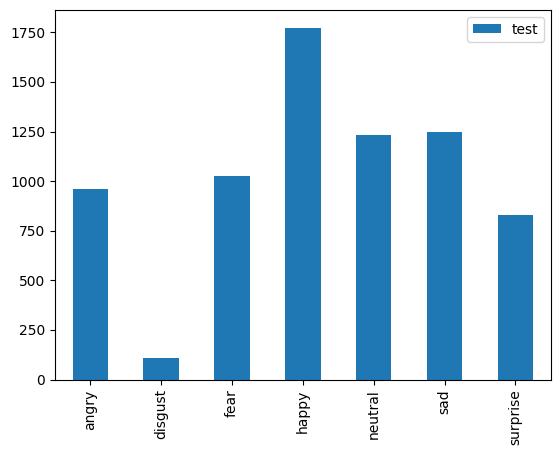

In [13]:
test_count.transpose().plot(kind = 'bar')

#ploting one image for each emotion

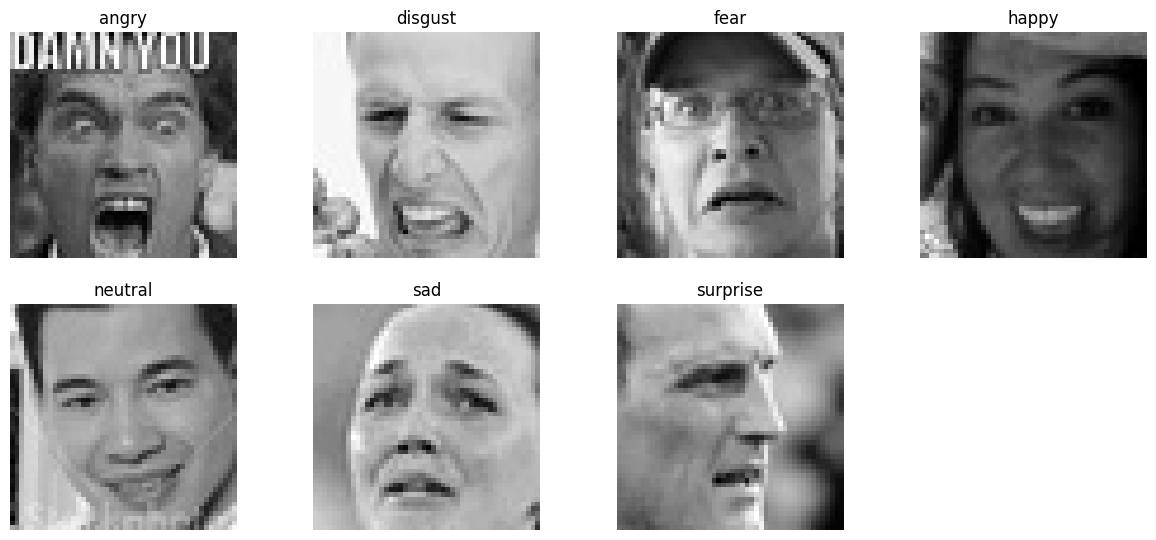

In [14]:
emotions = os.listdir(train_dir)
plt.figure(figsize = (15,10))

for i, emotions in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotions)
  img_path = os.path.join(folder, os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img, cmap= 'gray')
  plt.title(emotions)
  plt.axis('off')

#plotting random images fron given directory

In [15]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
  #retrive list of all file names in the directory
  image_filenames = os.listdir(directory_path)

  #if there are fewer image than requested, we will just show them all
  if len(image_filenames)<num_images:
    print(f'Only found {len(image_filenames)} images in {directory_path}, displaying them all.')
    num_images = len(image_filenames)

  #Randomly select 'num_images' no. of file names
  select_images = random.sample(image_filenames, num_images)

  #ploting the images
  fig, axes = plt.subplots(3,3, figsize=(5,5))
  axes = axes.ravel()

  for i, image_file in enumerate(select_images):
    image_path = os.path.join(directory_path, image_file)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f'Image: {class_name}')
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()


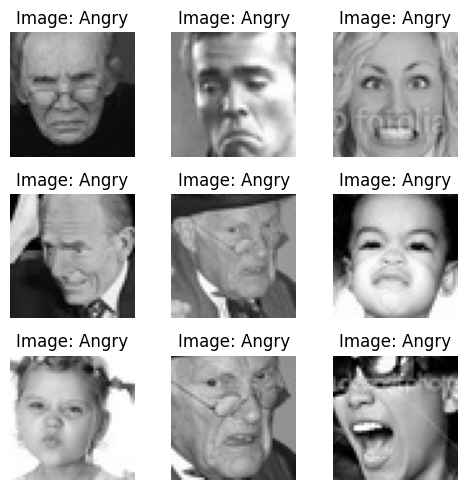

In [16]:
#palceholder for the directory path
angry_directory_path = '/content/drive/MyDrive/emo_detection/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

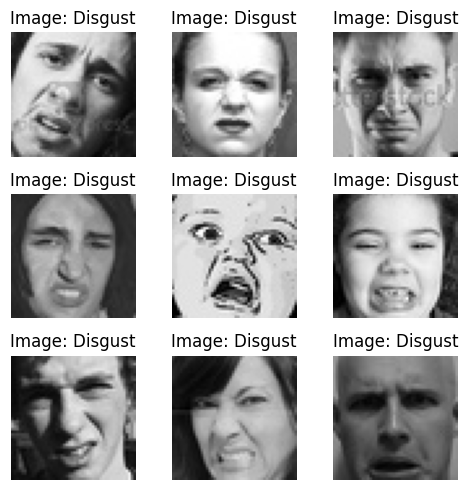

In [17]:
disgust_directory_path = '/content/drive/MyDrive/emo_detection/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name= "Disgust")

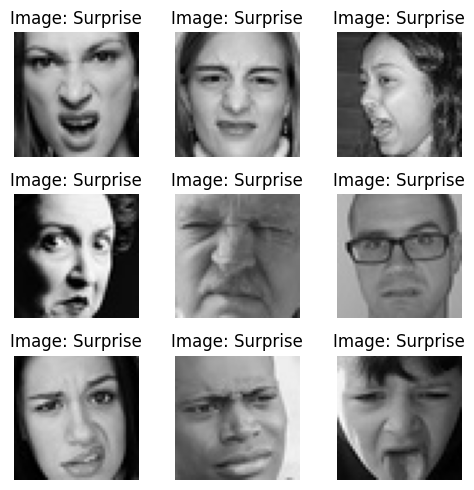

In [18]:
surprise_directory_path = '/content/drive/MyDrive/emo_detection/train/surprice'
plot_images_from_directory(disgust_directory_path, class_name= "Surprise")

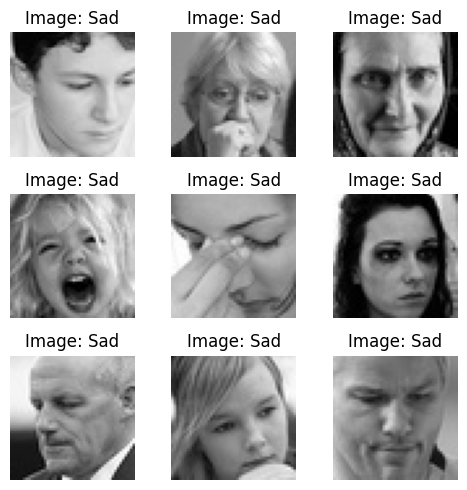

In [19]:
sad_directory_path = '/content/drive/MyDrive/emo_detection/train/sad'
plot_images_from_directory(sad_directory_path, class_name ="Sad")

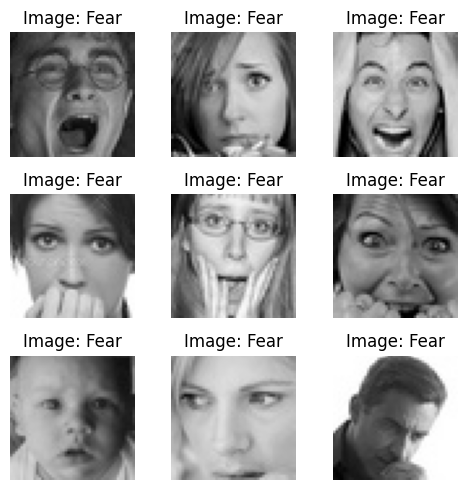

In [20]:
fear_directory_path = '/content/drive/MyDrive/emo_detection/train/fear'
plot_images_from_directory(fear_directory_path, class_name= 'Fear')

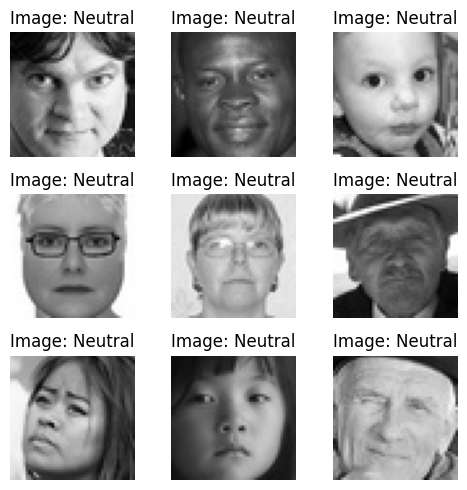

In [21]:
neutral_directory_path = '/content/drive/MyDrive/emo_detection/train/neutral'
plot_images_from_directory(neutral_directory_path, class_name= 'Neutral')


In [ ]:
happy_directory_path = '/content/drive/MyDrive/emo_detection/train/happy'
plot_images_from_directory(neutral_directory_path, class_name= 'Happy')

#Checking Shape and Channels

In [26]:
import cv2

In [28]:
image = '/content/drive/MyDrive/emo_detection/train/angry/Training_10120469.jpg'

img = cv2.imread(image)
#if the image is loaded successfully, print the pixel value

if img is not None:
  print("Shape: ", img.shape)
else:
  print("The image could not be loaded.")

Shape:  (48, 48, 3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [29]:
image_path = '/content/drive/MyDrive/emo_detection/train/angry/Training_10120469.jpg'

#load the image in gray scale
img =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is not None:
  print("Shape: ", img.shape)
else:
  print("The image could not be loaded.")

Shape:  (48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
# define paths to the train and validation
train_data_dir= '/content/drive/MyDrive/emo_detection/train'
test_data_dir = '/content/drive/MyDrive/emo_detection/test'

In [ ]:
#set parameer
img_width , img_height = 48, 48
batch_size = 64
epochs = 64
num_classes = 7

In [ ]:
#rescale the pixel values (0-255) to the [0,1] interval
data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [ ]:
#automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'

)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

In [ ]:
#accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels: ", train_class_labels)

# aCCESSING CLASS LABELs for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels: ", validation_class_labels)

# accessing class labels for the test data
test_class_labels = test_generator.class_indices
print("Test class labels: ", test_class_labels)

In [ ]:
# Initialising the CNN
model = Sequential()

# Adding comvolution layers with activation on the same line for clarity
model.add(Conv2D(32, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size =(3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3,3), padding= 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3,3), padding ='same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Flatten and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
#compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file ='/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes = True, Show_layers_names = True)